In [1]:
import numpy as np
import netCDF4 as nc
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as pltd
import matplotlib.patches as mpatches
from matplotlib import cm
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_map(data,vmin,vmax,cmap):
    ax = fig.add_subplot(spec[nrow,ncol+1], projection=proj)
    ax.set_global()
    ax.add_feature(cfeature.COASTLINE,zorder=11)
    if nrow > 1:
        ax.add_feature(cfeature.LAND,zorder=10)
    P = ax.pcolormesh(clon,clat,data,vmin=vmin,vmax=vmax,cmap=cmap,transform=ccrs.PlateCarree())    
    pos = ax.get_position()
    
    if nrow == 0: 
        ax.set_title(tim_sims_dict[tim]['plot_title'],fontsize=16)  
    
    if ncol == 0:
        # Historical Colorbar
        cax = fig.add_axes([pos.x0, pos.y0-.2*pos.height, pos.width, .1*pos.height])
        cbar = plt.colorbar(P,cax=cax,orientation='horizontal')
        cbar.ax.locator_params(nbins=5)
        # Variable and Unit labels
        ax.text(-.35, .45, field, fontsize=16, ha="center",transform = ax.transAxes)
        ax.text(-.35, .3, row_fields[field]['unit_str'], fontsize=15, ha="center",transform = ax.transAxes)
        
    else:
        
        if ncol == 1: 
            # Future Change colorbar
            cax = fig.add_axes([pos.x0+.04, pos.y0-.2*pos.height, 3.7*pos.width, .1*pos.height])
            cbar = plt.colorbar(P,cax=cax,orientation='horizontal')
            cbar.ax.locator_params(nbins=5)
            if nrow == 0:
                ax.annotate('', xy=(4, 1.2), xycoords='axes fraction', xytext=(.3, 1.2), 
                            arrowprops=dict(arrowstyle="simple", color='dimgrey'))
                plt.text(2.1, 1.3, 'End of 21$^{st}$ Century Conditions (2061-2100) Under Increasing Radiative Forcing Scenarios',
                         horizontalalignment='center', fontsize=16, verticalalignment='center',transform = ax.transAxes)
    
    

In [12]:
def plot_nut_map(ncol,data):
    ax = fig.add_subplot(spec[5,ncol+1], projection=ccrs.Mollweide(central_longitude=240))
    ax.add_feature(cfeature.COASTLINE,zorder=11)
    ax.add_feature(cfeature.LAND,zorder=10)
    
    P = ax.pcolormesh(lon_crn,lat_crn,data,vmin=1,vmax=5,transform = ccrs.PlateCarree(), cmap=mymap)
    pos = ax.get_position()
    
    
    if ncol == 0:
    # Variable labels
        ax.text(-.35, .3, 'Primary\nPhytoplankton\nLimiting Nutrient', fontsize=16, ha="center",transform = ax.transAxes)
        
    if ncol == 2:
        all_handles=[]
        for ncol in range(len(legend_titles)):
            leg_patch = mpatches.Patch(color=col_trm[ncol], label=legend_titles[ncol], linewidth = 2, edgecolor="black")
            all_handles.append(leg_patch)
        ax.legend(bbox_to_anchor=(-.8, -0.24, 2.5, .2), handles=all_handles, ncol = len(legend_titles), mode="expand", frameon=False, prop={'size': 15})
            
    plt.setp(ax.spines.values(), color='black',zorder=12)
      

In [4]:
def regress_drift_cor(data):
    
    ndim = np.ndim(data)
    # Read in regression information for variable drift correction
    pickle_fil = (field_var + '_dynamic_piC_0101-0351_stats.pkl')
    with open(pickle_fil,'rb') as f:  
        slope,p_value = pickle.load(f)
        
    # generate drift array for correction
    # regression slope, uniques for all lat,lon locations
    # an array of 1,2,3... number of months in variable timeseries
    # an array of number of months since beginning of historical 
            
    nmonths = np.arange(data.shape[0]).reshape((np.append(data.shape[0],np.ones(ndim-1)).astype(int)))
    drift_array = slope*(nmonths + tim_sims_dict[tim]['nt2'])
        
    # subtract out drift array     
    corrected_data = data - drift_array
        
    return(corrected_data)

In [5]:
def calc_lims():
    yn = tim_pers[tim]['yn']
    y1 = yn-nyrs + 1
    
    ncfile = file_dir + 'nut_lims_GFDL-ESM4_' + tim + '_r1i1p1f1_gr_' + str(y1) + '-' + str(yn) +'_clim.nc'
    fid_mod = nc.Dataset(ncfile)
    
    lon_bnds = fid_mod.variables['lon_bnds'][:] 
    lat_bnds = fid_mod.variables['lat_bnds'][:] 
    
    lon_crn = np.append(lon_bnds[:,0],lon_bnds[-1,-1])
    lat_crn = np.append(lat_bnds[:,0],lat_bnds[-1,-1])
    
    nmod_lat = len(lat_bnds)
    nmod_lon = len(lon_bnds)
    
    # INITIALIZE STORAGE ARRAYS
    nlim_weighted_month  = np.zeros((12,nmod_lat,nmod_lon))
    plim_weighted_month  = np.zeros((12,nmod_lat,nmod_lon))
    felim_weighted_month = np.zeros((12,nmod_lat,nmod_lon))
    pp_month = np.zeros((12,nmod_lat,nmod_lon))
    
    for m in range(12):
        

        # Constituent productivity terms
        intppdiat = fid_mod.variables['intppdiat'][m,:].squeeze()
        intppmisc = fid_mod.variables['intppmisc'][m,:].squeeze()
        intpppico = fid_mod.variables['intpppico'][m,:].squeeze()

        # Limitation terms (picophytoplankton)
        limnpico  = fid_mod.variables['limnpico'][m,:].squeeze()
        limppico  = fid_mod.variables['limppico'][m,:].squeeze()
        limfepico = fid_mod.variables['limfepico'][m,:].squeeze()

        # Diatoms
        limndiat  = fid_mod.variables['limndiat'][m,:].squeeze()
        limpdiat  = fid_mod.variables['limpdiat'][m,:].squeeze()
        limfediat = fid_mod.variables['limfediat'][m,:].squeeze()

        # Miscellaneous
        limnmisc  = fid_mod.variables['limnmisc'][m,:].squeeze()
        limpmisc  = fid_mod.variables['limpmisc'][m,:].squeeze()
        limfemisc = fid_mod.variables['limfemisc'][m,:].squeeze()

        nlim_weighted_month[m,:]  = (intppdiat*limndiat + intppmisc*limnmisc + intpppico*limnpico)/\
                                    (intppdiat + intppmisc + intpppico)

        plim_weighted_month[m,:]  = (intppdiat*limpdiat + intppmisc*limpmisc + intpppico*limppico)/\
                                    (intppdiat + intppmisc + intpppico);

        felim_weighted_month[m,:] = (intppdiat*limfediat + intppmisc*limfemisc + intpppico*limfepico)/\
                                    (intppdiat + intppmisc + intpppico);

        pp_month[m,:] = (intppdiat + intpppico + intppmisc)*86400*num_days[m]*6.625*12 
    
    # Monthly weighted mean
    sum_pp_month = np.sum(pp_month,axis=0)

    nlim_weighted  = np.sum(nlim_weighted_month*pp_month,axis=0)/sum_pp_month
    plim_weighted  = np.sum(plim_weighted_month*pp_month,axis=0)/sum_pp_month
    felim_weighted = np.sum(felim_weighted_month*pp_month,axis=0)/sum_pp_month

    aa = ~np.isfinite(felim_weighted)

    felim = felim_weighted - np.min(np.stack((nlim_weighted,plim_weighted)),axis=0)
    felim[aa] = np.nan
    nlim  = nlim_weighted  - np.min(np.stack((felim_weighted,plim_weighted)),axis=0)
    nlim[aa] = np.nan
    plim  = plim_weighted  - np.min(np.stack((nlim_weighted,felim_weighted)),axis=0)
    plim[aa] = np.nan

    liebig_macro = np.min(np.stack((nlim_weighted,plim_weighted)),axis=0)
    liebig = np.min(np.stack((liebig_macro,felim_weighted)),axis=0)
    
    
    lim_ind = np.empty((nmod_lat,nmod_lon))
    lim_ind[nlim <= 0] = 1;
    lim_ind[(plim <= 0) * (plim > -0.25)] = 1
    lim_ind[plim <= -0.25] = 1
    lim_ind[(felim <= 0) * (felim > -0.25)] = 4.5
    lim_ind[felim <= -0.25] = 5
    
    return lim_ind, lon_crn, lat_crn


In [6]:
# updated colormaps
nrow=129
nrow2 = 2*nrow
# Relative Change Plot
colors2 = plt.cm.hot(np.linspace(1, 0, nrow2))

colors3 = np.ones((nrow,4))
colors3[:int(2*nrow/3),0]=0
colors3[-int(nrow/3):,0]=np.linspace(0, 1,int(nrow/3))
colors3[:int(nrow/3),1]=0
colors3[int(nrow/3):-int(nrow/3):,1]=np.linspace(0, 1, int(nrow/3))
colors3[:int(nrow/3),2]=np.linspace(0.5, 1, int(nrow/3))

# combine them and build a new colormap
colors = np.vstack((colors3, colors2))
change_map = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

# Precip relative change plot
colors2 = plt.cm.hot(np.linspace(1, 0, nrow))

colors3 = np.ones((nrow2,4))
colors3[:int(2*nrow2/3),0]=0
colors3[-int(nrow2/3):,0]=np.linspace(0, 1,int(nrow2/3))
colors3[:int(nrow2/3),1]=0
colors3[int(nrow2/3):-int(nrow2/3):,1]=np.linspace(0, 1, int(nrow2/3))
colors3[:int(nrow2/3),2]=np.linspace(0.5, 1, int(nrow2/3))

# combine them and build a new colormap
colors = np.vstack((colors3, colors2))
precip_change_map = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors).reversed()

# Precipitation color map
colors3 = np.ones((nrow,4))
colors3[:int(2*nrow/3),0]=0
colors3[-int(nrow/3):,0]=np.linspace(0, 1,int(nrow/3))
colors3[:int(nrow/3),1]=0
colors3[int(nrow/3):-int(nrow/3):,1]=np.linspace(0, 1, int(nrow/3))
colors3[:int(nrow/3),2]=np.linspace(0.5, 1, int(nrow/3))
# combine them and build a new colormap
wet_map = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors3)


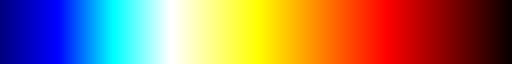

In [7]:
change_map

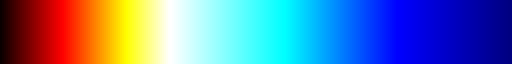

In [8]:
precip_change_map

In [10]:
ocean_grid_file = 'ocean_hgrid.nc'

row_fields = {'Precipitation':{'vars': {'pr'},'realm':'atmosphere',
                               'stoic_fact':365*24*60*60/100, 'unit_str':'(x10$^{2}$ kg m$^{-2}$ yr$^{-1}$)',
                               'his_vmin':0,'his_vmax':40,'his_cmap':wet_map.reversed(),
                               'dif_vmin':-1,'dif_vmax':2,'dif_lev':0,'dif_cmap':precip_change_map},
             'Moisture in\n Upper Portion\n of Soil Column':{'vars':{'mrsos'},'realm':'land',
                                          'stoic_fact':1, 'unit_str':'(kg m$^{-2}$)',
                                          'his_vmin':0,'his_vmax':40,'dif_lev':0,'his_cmap':'Blues',
                                          'dif_vmin':-.2,'dif_vmax':.2,'dif_cmap':'BrBG'},
             'Column-Integrated\n Atmosphere Dust':{'vars':{'sm_dust_col','lg_dust_col'},'realm':'atmosphere',
                                          'stoic_fact':100000, 'unit_str':'(x10$^{-2}$ g m$^{-2}$)',
                                          'his_vmin':0,'his_vmax':20,'dif_lev':0,'his_cmap':'hot_r',
                                          'dif_vmin':-1,'dif_vmax':2,'dif_cmap':change_map},              
             'Total Atmosphere\n Dust Deposition':{'vars':{'wetdust','drydust'},'realm':'atmosphere',
                                         'stoic_fact':1000*(365*24*60*60),'unit_str':'(g m$^{-2}$ y$^{-1}$)', 
                                         'his_vmin': 0, 'his_vmax':8, 'his_cmap':'hot_r',
                                         'dif_vmin':-1,'dif_vmax':2, 'dif_lev':0, 'dif_cmap':change_map},
             'Total Ocean\n Iron Deposition':{'vars':{'dep_wet_fed','dep_dry_fed'}, 'realm':'ocean',
                                         'stoic_fact':1000000*(365*24*60*60), 'unit_str':'($\mu$mol m$^{-2}$ yr$^{-1}$)',
                                         'his_vmin':0,'his_vmax':80,'dif_lev':0,'his_cmap':'hot_r',
                                         'dif_vmin':-1,'dif_vmax':2,'dif_cmap':change_map,},
             'Primary\nPhytoplankton\n Nutrient Limitation':'nut_lim_plot',
             'Depth Integrated\n(0-100m)\n Primary Production':{'vars':{'intpp'}, 'realm':'ocean_regrid',
                                                                'stoic_fact': 12*(365*24*60*60)/100, 
                                                                'unit_str':'(x10$^{2}$ g C m$^{-2}$ yr$^{-1}$)',
                                                                'his_vmin':0,'his_vmax':4,'his_cmap':'Greens',
                                                                'dif_vmin':-.5,'dif_vmax':.5,'dif_cmap':'BrBG'},
             }

tim_sims = ['his',
            'ssp126',
            'ssp245',
            'ssp370',
            'ssp585']

tim_sims_dict = {'his':{'tim_str':'1975-2014','nt2':12*(1975-1850)+1,
                        'plot_title':('Historical Conditions\n(' + str(1975) + '-' + str(2014) + ')'),},
                 'ssp126':{'tim_str':'2061-2100','nt2':12*(2015-1850)+1,
                           'plot_title':'SSP1-2.6'},
                 'ssp245':{'tim_str':'2061-2100','nt2':12*(2015-1850)+1,
                           'plot_title':'SSP2-4.5'},
                 'ssp370':{'tim_str':'2061-2100', 'nt2':12*(2015-1850)+1,
                           'plot_title':'SSP3-7.0'},
                 'ssp585':{'tim_str':'2061-2100', 'nt2':12*(2015-1850)+1,
                           'plot_title':'SSP5-8.5'}}

# Creating a Colormap nutrient limitation color map
col_trm = ['#4460ff', '#fd631a', 'red']
mymap = mcolors.ListedColormap([col_trm[0], 'white', 'white', 'white', 'white', 'white', 'white', col_trm[1], col_trm[2]])
legend_titles = ['Macro Nutrient [N or P]', 'Weakly Fe', 'Fe']

Precipitation
Moisture in
 Upper Portion
 of Soil Column
Column-Integrated
 Atmosphere Dust
Total Atmosphere
 Dust Deposition
Total Ocean
 Iron Deposition
Primary
Phytoplankton
 Nutrient Limitation
Depth Integrated
(0-100m)
 Primary Production


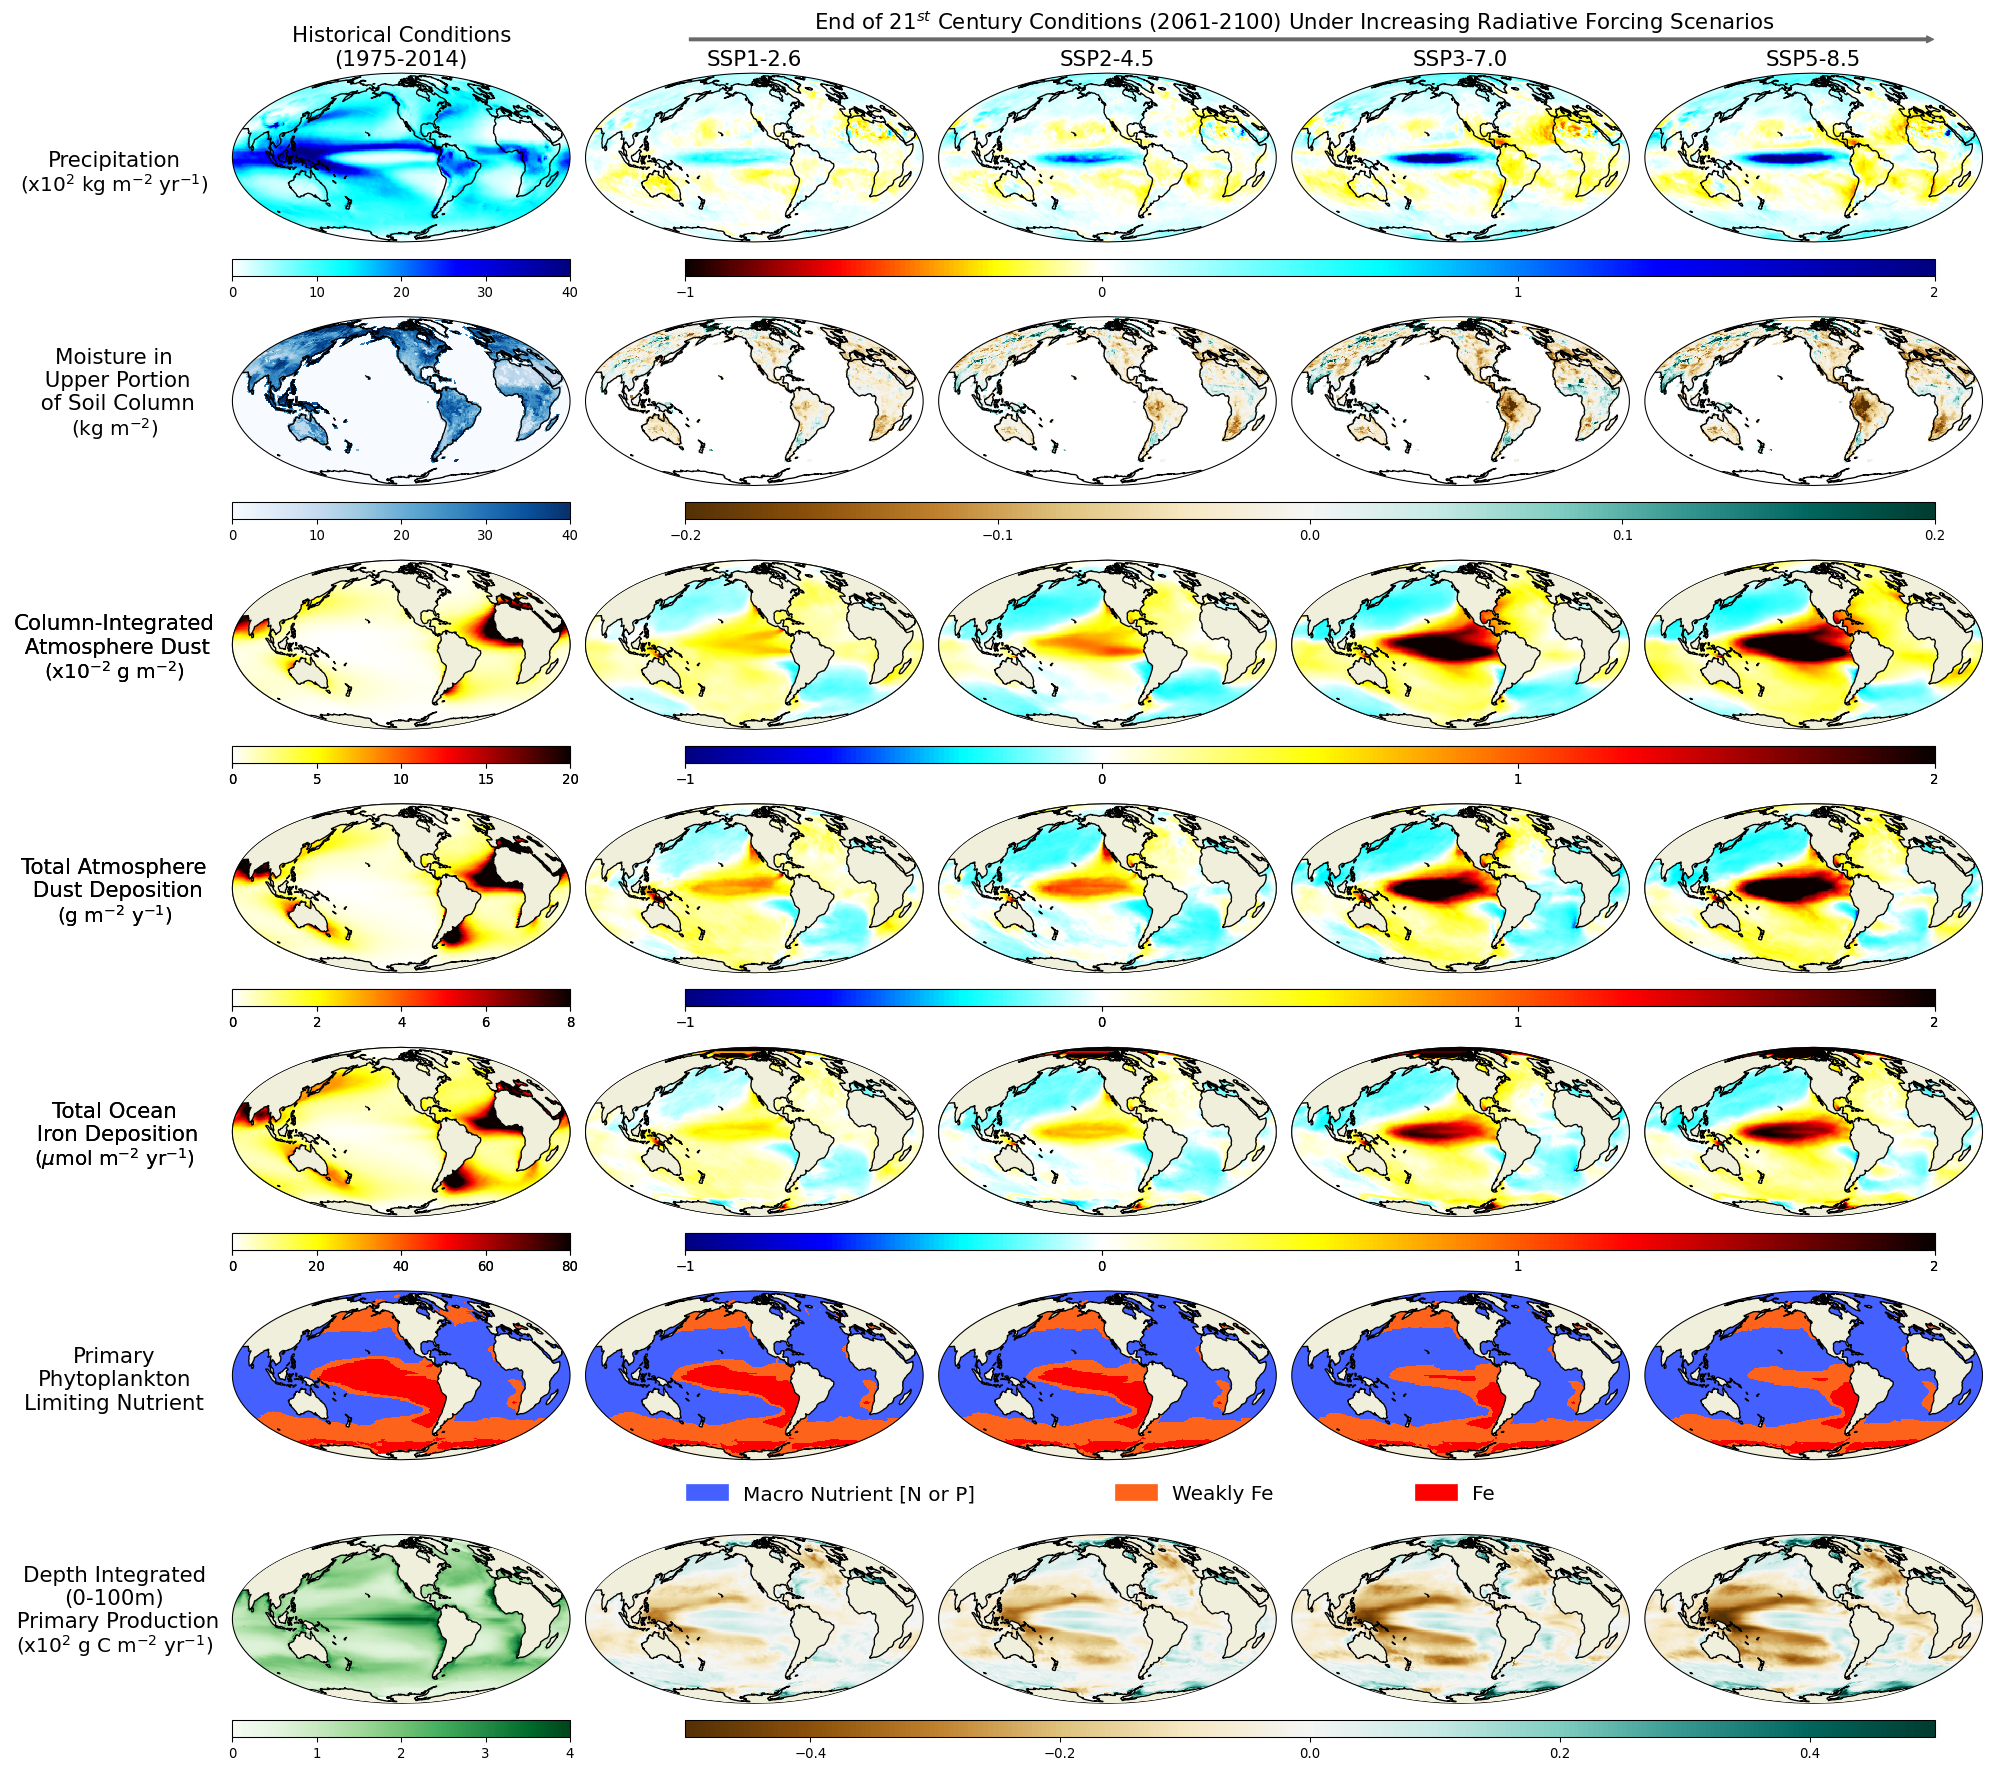

In [13]:
# HORIZONTAL
proj = ccrs.Mollweide(central_longitude=240)
fig = plt.figure(figsize=(26,23),dpi=96)
widths = [.5,1,1,1,1,1]
spec = fig.add_gridspec(ncols=6, nrows=7,wspace=0.05,hspace=0.02,width_ratios=widths)

for field, nrow in zip(row_fields,range(len(row_fields))):
    print(field)
    for tim, ncol in zip(tim_sims,range(len(tim_sims))):
        
        if row_fields[field] == 'nut_lim_plot':
            if tim == 'his':
                nut_lim_fil = 'nutrient_limitations_dynamic_historical' 
                npzdata = np.load((nut_lim_fil +'.npz'))
                lon_crn = npzdata['arr_1']
                lat_crn = npzdata['arr_2']
                lon_crn, lat_crn = np.meshgrid(lon_crn, lat_crn)
            else:
                nut_lim_fil = 'nutrient_limitations_dynamic_' + tim
                npzdata = np.load((nut_lim_fil +'.npz'))
            
            data = npzdata['arr_0']   
            plot_nut_map(ncol,data)    
        else: 
            first_var = None
            stoic_fact = row_fields[field]['stoic_fact']
            for field_var in row_fields[field]['vars']:

                ncfil = field_var + '_' + tim_sims_dict[tim]['tim_str'] + '_' + tim + '.nc'
                fid = nc.Dataset(ncfil)
            
                var_val_all = fid.variables[field_var][:].squeeze()
            
                # Drift Correction
                var_val_all = regress_drift_cor(var_val_all)
                
                #multiply by any unit conversion, stoic_fact
                var_val_all = stoic_fact*(var_val_all)
        
                if first_var is None:
                    # only for combined variables; won't be used in singular variables
                    first_var = var_val_all
                else:
                    # add wet and dry deposition together
                    var_val_all = var_val_all + first_var
                
               # When historical, save historical values
                if tim == 'his':
                    var_his = np.mean(var_val_all,axis=0)
                    var_val_all_his = var_val_all
                
                    if row_fields[field]['realm'] == 'ocean':
                        fid_oc_grd = nc.Dataset(ocean_grid_file)
                        lon = fid_oc_grd.variables['x'][1::2,1::2]
                        lat = fid_oc_grd.variables['y'][1::2,1::2]
                        clon=fid_oc_grd.variables['x'][::2,::2]
                        clat=fid_oc_grd.variables['y'][::2,::2]
        
                    else:
                        lat = fid.variables['lat'][:]
                        lon = fid.variables['lon'][:]
                        clat = np.append(fid.variables['lat_bnds'][:,0],fid.variables['lat_bnds'][-1,-1])
                        clon = np.append(fid.variables['lon_bnds'][:,0],fid.variables['lon_bnds'][-1,-1])
            
                       # plot historical maps
                    plot_map(var_his,
                         row_fields[field]['his_vmin'],
                         row_fields[field]['his_vmax'],
                         row_fields[field]['his_cmap']) 
                else:
                    # store all future values for time series
                    var_dif =  (np.mean(var_val_all,axis=0)-var_his)/var_his
                    #plot difference map
                    plot_map(var_dif,
                         row_fields[field]['dif_vmin'],
                         row_fields[field]['dif_vmax'],
                         row_fields[field]['dif_cmap'])

plt.savefig(('Figure1_Revision_ssp_fe_dep_drivers_&_responses'),bbox_inches = 'tight')